<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/XAnalyzing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time

df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis(1) (1).csv')
df2 = df[df['train'] == 1]
print(df2['y'].max())
ymax_train1 = df2['y'].max()
# sve sa train = 0 y = max(y) + 1

#for i in range(df.shape[0]):
#  if(df.iloc[i]['train'] == 0):
#    df.loc[i, 'y'] = ymax_train1 + 1

lower_bound = df['n'] * df['av.length'] / df['m']
lower_bound = lower_bound.astype('int') + 1

upper_bound = np.minimum(df[' LPTUB'], df[' SLACKUB'])
df['rel. bound'] = (upper_bound-lower_bound)/(upper_bound)

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name', 'CPLEXStatus','type']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']

X['m/n'] = X['m/n'].apply(lambda x: x*100000)
X['(m/n)^2'] = X['(m/n)^2'].apply(lambda x: x*100000)
X['(m/n)^3'] = X['(m/n)^3'].apply(lambda x: x*100000)
X['rel. bound'] = X['rel. bound'].apply(lambda x: x*10000)
print(X.head())
shuffled = shuffled.drop([  'index', 'inst.name', 'type', 'train', 'index'], axis = 1)

19.907111
   subtype  class  indeks    n   m  n/m  (n/m)^2  (n/m)^3      m/n  (m/n)^2  \
0        9      6       3  162  36  4.5    20.25   91.125  22222.2   4938.3   
1        1      6       2  140  70  2.0     4.00    8.000  50000.0  25000.0   
2        5      5       5  180  60  3.0     9.00   27.000  33333.3  11111.1   
3       11      2       5  162  27  6.0    36.00  216.000  16666.7   2777.8   
4        3      2       6  180  72  2.5     6.25   15.625  40000.0  16000.0   

   ...     std.dev  median  range  min  max    k   LPTUB   SLACKUB  train  \
0  ...  142.086929   439.5    476  170  646  143    2002      1925      1   
1  ...  121.433525   349.0    408  141  549  109     729       729      1   
2  ...   46.397007    99.5    221    1  222  109     308       299      1   
3  ...   21.859871    63.5     80   20  100   70     365       365      1   
4  ...   23.428270    57.0     80   20  100   72     159       148      1   

   rel. bound  
0   98.701299  
1  288.065844  
2  2

In [2]:
X_corr = shuffled.corr()['y'].abs().sort_values(ascending=False)
X_corr

y             1.000000
rel. bound    0.476547
m             0.442684
subtype       0.430256
m/n           0.418171
(m/n)^2       0.411345
(m/n)^3       0.382118
n/m           0.340878
av.length     0.306203
median        0.305065
min           0.302683
max           0.297263
(n/m)^2       0.289090
range         0.283401
std.dev       0.253432
(n/m)^3       0.250783
k             0.215968
class         0.211151
n             0.160885
 SLACKUB      0.017141
indeks        0.007393
 LPTUB        0.004023
Name: y, dtype: float64

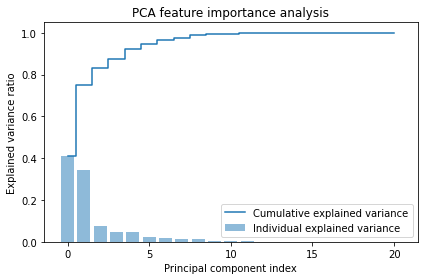

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
shuffled = shuffled.drop(['y'], axis = 1)
sc.fit(shuffled)
X_train_std = sc.transform(shuffled)

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_std)

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('PCA feature importance analysis')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores

vif_scores(X).round(1)


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Independent Features,VIF Scores
0,subtype,12123.7
1,class,10.8
2,indeks,4.7
3,n,47.9
4,m,24.7
5,n/m,300203.8
6,(n/m)^2,454033.7
7,(n/m)^3,88380.8
8,m/n,70162.0
9,(m/n)^2,90081.8


In [5]:
corr = X.corr()
corr.style.background_gradient()

,subtype,class,indeks,n,m,n/m,(n/m)^2,(n/m)^3,m/n,(m/n)^2,(m/n)^3,av.length,std.dev,median,range,min,max,k,LPTUB,SLACKUB,train,rel. bound
subtype,1.000000,-0.000000,-0.000000,0.008854,-0.648089,0.919441,0.844094,0.781564,-0.994674,-0.964704,-0.914630,0.002786,0.002849,0.002652,0.002714,0.002829,0.002830,0.005747,0.372642,0.379096,0.208720,-0.737954
class,-0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.682816,0.651998,0.682142,0.660820,0.660191,0.682595,0.417605,0.540428,0.534715,-0.214477,-0.017191
indeks,-0.000000,-0.000000,1.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.002080,-0.002397,-0.002367,-0.001470,0.004281,-0.000188,-0.000123,-0.001500,-0.001376,0.006860,0.000685
n,0.008854,-0.000000,0.000000,1.000000,0.671534,0.018212,0.024270,0.029337,-0.007408,-0.005316,-0.005099,0.314771,0.332278,0.309328,0.337380,0.248929,0.328105,0.741326,0.257854,0.255852,-0.141191,0.039034
m,-0.648089,-0.000000,-0.000000,0.671534,1.000000,-0.587461,-0.532768,-0.487548,0.650812,0.637933,0.610661,0.211427,0.223364,0.207894,0.226995,0.166177,0.220452,0.498816,-0.111533,-0.117923,-0.279756,0.509653
n/m,0.919441,-0.000000,-0.000000,0.018212,-0.587461,1.000000,0.985121,0.956690,-0.905423,-0.813919,-0.729471,0.005682,0.005947,0.005484,0.005884,0.004938,0.005861,0.012053,0.410020,0.417014,0.164822,-0.623383
(n/m)^2,0.844094,-0.000000,0.000000,0.024270,-0.532768,0.985121,1.000000,0.992114,-0.824205,-0.714125,-0.621992,0.007554,0.007957,0.007318,0.007953,0.006256,0.007824,0.016148,0.407195,0.414057,0.139617,-0.546551
(n/m)^3,0.781564,-0.000000,0.000000,0.029337,-0.487548,0.956690,0.992114,1.000000,-0.757230,-0.639315,-0.545881,0.009121,0.009637,0.008853,0.009679,0.007372,0.009466,0.019569,0.398371,0.404988,0.121014,-0.487394
m/n,-0.994674,-0.000000,-0.000000,-0.007408,0.650812,-0.905423,-0.824205,-0.757230,1.000000,0.981499,0.941804,-0.002347,-0.002354,-0.002208,-0.002168,-0.002667,-0.002355,-0.004729,-0.366038,-0.372219,-0.202408,0.733395
(m/n)^2,-0.964704,0.000000,0.000000,-0.005316,0.637933,-0.813919,-0.714125,-0.639315,0.981499,1.000000,0.988191,-0.001706,-0.001649,-0.001571,-0.001416,-0.002319,-0.001672,-0.003287,-0.327892,-0.333220,-0.198773,0.726270


In [6]:
X_modified = X.drop(['max','subtype','indeks',  '(n/m)^2', '(n/m)^3', 'm/n', '(m/n)^2', '(m/n)^3', 'class', 'm', 'av.length', 'median', 'range', 'min'], axis = 1)
vif_scores(X_modified).round(1)

,Independent Features,VIF Scores
0,n,24.2
1,n/m,7.7
2,std.dev,26.2
3,k,65.0
4,LPTUB,4749.9
5,SLACKUB,4604.9
6,train,10.3
7,rel. bound,2.5


In [7]:
corr = X_modified.corr()
corr.style.background_gradient()

,n,n/m,std.dev,k,LPTUB,SLACKUB,train,rel. bound
n,1.000000,0.018212,0.332278,0.741326,0.257854,0.255852,-0.141191,0.039034
n/m,0.018212,1.000000,0.005947,0.012053,0.410020,0.417014,0.164822,-0.623383
std.dev,0.332278,0.005947,1.000000,0.829030,0.764369,0.756846,-0.360503,-0.055058
k,0.741326,0.012053,0.829030,1.000000,0.614147,0.608600,-0.308143,0.000035
LPTUB,0.257854,0.410020,0.764369,0.614147,1.000000,0.999753,-0.080142,-0.262516
SLACKUB,0.255852,0.417014,0.756846,0.608600,0.999753,1.000000,-0.067822,-0.267364
train,-0.141191,0.164822,-0.360503,-0.308143,-0.080142,-0.067822,1.000000,-0.130825
rel. bound,0.039034,-0.623383,-0.055058,0.000035,-0.262516,-0.267364,-0.130825,1.000000
